In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from lib import pseudo 
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('error', category=UnicodeWarning)
import time 
import sys
import h5py

%matplotlib inline


from lib.eval import NSECostFun
from lib.utils import _kxFun, _kzFun

# Mean velocity equation for longitudinal grooves

I set $u_{total}$ as $u + U$, with $U=1-Y^2$. In flat-walled geometry, this profile has zero $z$-derivative. But now it has non-zero derivatives that must appear in the equations. 

The only term I need to worry about is $U_{zz}$ which appears in the diffusion term, because I'm doing longitudinal only (so $U_x=0$). 

The easy way out is to add $\frac{1}{Re}U_{zz}$ to the linear term in the cost function. The question, though, is if the other term due to $U$ balances out the pressure gradient. That is, if $P_x= -2/Re$ is valid. Well, it doesn't matter. Under whatever normalization, I can say the imposed pressure gradient is $-2/Re$. The velocity must adjust itself (in the normalized units) to match this pressure gradient. The $Re$ need not be based on the actual centerline velocity anymore. Modification to the velocity profile come from the $u_{0,0}$ terms. All I need to worry about is the $U_{zz}$ in the diffusion term that was unaccounted for. 

I can either add the $U_{zz}$ term explicitly. Or, I can add $U_y$ and $U_{yy}$ at the appropriate places in the calculation of $u_{zz}$ for mode 0. 

Actually, it is not that easy. Because $U$ will appear in $z$ derivatives of adjacent modes. Here's how to do it.

The $x$ and $y$ derivatives are unaffected by the domain transformation. The $U$ profile needs to be added only when calculating the $z$ derivatives. I can just do that directly by adding $U$, $U_y$, and $U_{yy}$ to the y-derivatives array when calculating these derivatives. Remember that $U_{X}$ and $U_{Z}$ are zero (in the transformed domain), so I don't have to add to x-derivatives and z-derivatives.

To test the whole thing, I'll use the analytical solution for longitudinal grooves (laminar)

$$ u(Y,Z) = (1-Y^2) -2\epsilon^2\beta^2(1-Y^2) + (e^{i\beta Z}+e^{-i\beta Z})\frac{\epsilon \beta^2}{3}(Y^3 -Y) +  (e^{2i\beta Z}+e^{-2i\beta Z})(\epsilon^2 \beta^2)(1 -Y^2) $$

In [3]:
alpha = 0.5; beta = 10.; L = 1; M = 3
N = 10
y, DM = pseudo.chebdif(N,2)
D1 = np.ascontiguousarray(DM[:,:,0])
D2 = np.ascontiguousarray(DM[:,:,1])
Re = 100.
U = 1.-y**2; Uy = -2.*y

kxArr = _kxFun(alpha, L)
kzArr = _kzFun(beta, M)
state = np.zeros((kxArr.size, kzArr.size,4,N,2))

flowDict = {'y':y, 'Re':Re, \
            'U':U, 'Uy':Uy, 'D1':D1, 'D2':D2, 'N':N}

def costFun(realState,kzArr,flowDict):
    complexState = _real2compFull(realState)
    cost = NSECostFun(complexState, kxArr, kzArr, flowDict,
                      padding=True,wavy=True,mode=1)
    return cost

def subCostFun(partialRealState,fullComplexState,kzArr,flowDict,ix=0, iz=0):
    fullComplexState[ix,iz] = _real2compMode(partialRealState)
    cost = NSECostFun(fullComplexState, kxArr, kzArr, flowDict, 
                      padding=True,wavy=True,mode=1)
    return cost

def _comp2real(arr): 
    arrReal = np.expand_dims(arr,-1)
    arrImag = np.expand_dims(arr,-1)
    return np.concatenate((arrReal, arrImag), axis=-1)

def _real2compMode(arr):
    arr = arr.reshape((4,N,2))
    arrReal = arr[:,:,0]
    arrImag = arr[:,:,1]
    return arrReal + 1.j*arrImag

def _real2compFull(arr):
    arr = arr.reshape((kxArr.size, kzArr.size, 4, N, 2))
    return arr[:,:,:,:,0] + 1.j*arr[:,:,:,:,1]



0.0001, 0.0001, 1e-08, 2.17e-14
0.0001, 0.001, 1e-07, 2.17e-13
0.0001, 0.01, 1e-06, 2.17e-12
0.0001, 0.1, 1e-05, 2.17e-11
0.0001, 1, 0.0001, 1.3e-09
0.001, 0.0001, 1e-07, 2.17e-12
0.001, 0.001, 1e-06, 2.17e-11
0.001, 0.01, 1e-05, 2.17e-10
0.001, 0.1, 0.0001, 2.17e-09
0.001, 1, 0.001, 1.3e-07
0.01, 0.0001, 1e-06, 2.17e-10
0.01, 0.001, 1e-05, 2.17e-09
0.01, 0.01, 0.0001, 2.17e-08
0.01, 0.1, 0.001, 2.17e-07
0.01, 1, 0.01, 1.3e-05
0.1, 0.0001, 1e-05, 2.17e-08
0.1, 0.001, 0.0001, 2.17e-07
0.1, 0.01, 0.001, 2.17e-06
0.1, 0.1, 0.01, 2.17e-05
0.1, 1, 0.1, 0.00132
1, 0.0001, 0.0001, 2.16e-06
1, 0.001, 0.001, 2.16e-05
1, 0.01, 0.01, 0.000216
1, 0.1, 0.1, 0.00217
1, 1, 1, 0.455


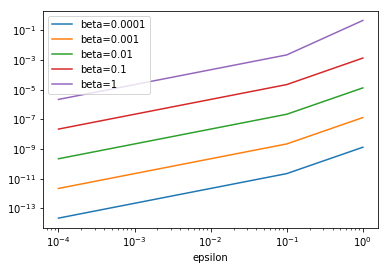

In [4]:
epsArr = 10** np.arange(-4.,0.5)
betaArr = 10**np.arange(-4.,0.5)
costArr = np.zeros((betaArr.size, epsArr.size))
i0= 0
for beta in betaArr:
    kzArr = _kzFun(beta, M)
    i1=0
    for eps in epsArr:
        flowDict.update({'eps':eps, 'beta':beta})
        state = np.zeros((kxArr.size, kzArr.size,4,N,2))
        #=================================
        state[0,0,0,:,0] = -2.*eps**2 * beta**2 * (1.-y**2)
        state[0,1,0,:,0] = (y**3-y)*(eps* beta**2)/3.
        state[0,2,0,:,0] = (1.-y**2)*(eps**2 * beta**2)
        #===================
        cost = costFun(state, kzArr, flowDict)
        print("%.3g, %.3g, %.3g, %.3g"%(beta, eps, beta*eps, cost))
        costArr[i0,i1] = cost
        i1+=1
    plt.loglog(epsArr, costArr[i0], label="beta=%.3g"%betaArr[i0])
    i0 += 1

plt.legend()
plt.xlabel("epsilon")
plt.show()
    



### Look's good enough to me

In [5]:
beta=1.; eps = 0.05
flowDict.update({'eps':eps, 'beta':beta})
kzArr = _kzFun(beta, M)
state0 = np.zeros((kxArr.size, kzArr.size,4,N,2))
#=================================
state0[0,0,0,:,0] = -2.*eps**2 * beta**2 * (1.-y**2)
#state[0,1,0,:,0] = (y**3-y)*(eps* beta**2)/3.
state0[0,2,0,:,0] = (1.-y**2)*(eps**2 * beta**2)
state = np.copy(state0)

costList = []
def minFun(outerIter, innerIter, method, 
           shuffleFlag=False, fullState=False):
    state = np.copy(state0)
    print("Cost before iterating: %g" %costFun(state,kzArr, flowDict) )
    print( time.strftime("%H:%M:%S", time.localtime()) )
    print()
    print("Running method %s..."%method)
    #ixList = np.arange(kxArr.size)
    izList = np.arange(kzArr.size)
    ixList = np.array([0])
    assert state.shape == (kxArr.size, kzArr.size, 4, N,2)
    for oiter in range(outerIter):
        if shuffleFlag: np.random.shuffle(ixList)
        for ix in ixList:
            kxList = [kxArr[ix]]
            if shuffleFlag: np.random.shuffle(izList)
            for iz in izList:
                assert state.shape == (kxArr.size, kzArr.size, 4, N,2)
                kzList = [kzArr[iz]]

                partState = state[ix,iz]
                def tmpCostFun(arr): 
                    return subCostFun(arr, _real2compFull(state),kzArr, flowDict,ix=ix,iz=iz)
                res = minimize(tmpCostFun, partState, method=method, 
                               options={'disp': False, 'maxiter':innerIter})
                state[ix,iz] = res.x.reshape(4,N,2)
                
                
        cost = costFun(state,kzArr, flowDict)
        if oiter%10 == 0:
            print("Cost after iter %03d:%.3g"%(oiter, cost) )
            print( time.strftime("%H:%M:%S", time.localtime()) )
        costList.append(cost)
        
    return state

In [6]:
state1 = minFun(50,5, method='BFGS')
print();print();print();print()
state2 = minFun(50,15, method='BFGS')
print();print();print();print()
state3 = minFun(50,50, method='BFGS')



Cost before iterating: 0.00080839
21:25:13

Running method BFGS...
Cost after iter 000:0.000786
21:25:15
Cost after iter 010:0.000727
21:25:46
Cost after iter 020:0.000724
21:26:55
Cost after iter 030:0.000724
21:28:13
Cost after iter 040:0.000723
21:29:35




Cost before iterating: 0.00080839
21:31:00

Running method BFGS...
Cost after iter 000:0.000803
21:31:13
Cost after iter 010:0.000748
21:32:55
Cost after iter 020:0.000747
21:34:54
Cost after iter 030:0.000747
21:36:53
Cost after iter 040:0.000747
21:38:52




Cost before iterating: 0.00080839
21:40:28

Running method BFGS...
Cost after iter 000:0.000803
21:40:43
Cost after iter 010:0.00068
21:43:40
Cost after iter 020:0.000679
21:46:16
Cost after iter 030:0.000678
21:48:28
Cost after iter 040:0.000678
07:58:43


# Gradient for complex fields

## Cost function expansion
The cost $G$ is calculated in the following steps.
$$G = \sqrt{F} \tag{+4}$$
$$F = \sum_k \sum_l \sum_m \sum_n q_n \big(|L^{k}|^2 + |Q^{k}|^2\big)_{l,m,n}\tag{+3}$$
$k$ is for coordinate direction, $(l,m)$ for Fourier mode, $n$ for wall-normal. The $|.|$ indicate absolute values, or $|.|^2$ indicate a complex number times its conjugate. Note that we are dealing with scalars here, with coordinate dependence tucked away into the summations. 

The equations are numbered in order of when they are computed, with the + indicating forward propagation. Later, we'll look at the corresponding back-prop equations to compute gradients.

\begin{align}
L^0_{l,m} &= a_0 u + a_1 u' + a_2  u'' + b_{00} p + b_{01} p'  + c_0 v \tag{+2.0}\\
L^1_{l,m} &= a_0 v + a_1 v' + a_2  v'' + b_{10} p + b_{11} p'   \tag{+2.1}\\
L^2_{l,m} &= a_0 w + a_1 w' + a_2  w'' + b_{20} p + b_{21} p'   \tag{+2.2}\\
L^3_{l,m} &= d_0 u + d_1 v' + d_2  w  + d_3 w'    \tag{+2.3}
\end{align}
where the subscript on $u,v,w,p$ denotes (wall-normal) derivative order. This is a general expression. The $c_0 v$ term in (+2.0) is due to $vU'$. The $d_2$ and $d_3$ terms appear in (2.3) because, for longitudinal grooves, $\partial_z = \partial_Z + T_z \partial_Y$. (+2.3) is divergence, and has only $u_x$, $v'$, and $w_z$, the last containing two terms because of grooves. 

__In the above expansions (+2.x), as well as below in quadratic (+1.x), the coefficients and velocity derivatives can be complex. They are not constant across (l,m) because some of them contain wavenumbers.__

The quadratic term, 
\begin{align}
    Q^0 _{l+l',m+m'} =& f_{00} u_{l,m}u_{l',m'} + f_{01} u_{l',m'} u_{l,m}
                            + f_{10} v_{l,m}u'_{l',m'} + f_{11} v_{l',m'} u'_{l,m}\\
                            &+ f_{20} w_{l,m}u_{l',m'} + f_{21} w_{l',m'} u_{l,m}  
                            + f_{22} w_{l,m}u'_{l',m'} + f_{23} w_{l',m'} u'_{l,m}  \tag{+1.1}\\
    Q^1 _{l+l',m+m'} =& g_{00} u_{l,m}v_{l',m'} + g_{01} u_{l',m'} v_{l,m}
                            + g_{10} v_{l,m}v'_{l',m'} + g_{11} v_{l',m'} v'_{l,m}\\
                            &+ g_{20} w_{l,m}v_{l',m'} + g_{21} w_{l',m'} v_{l,m}  
                            + g_{22} w_{l,m}v'_{l',m'} + g_{23} w_{l',m'} v'_{l,m}  \tag{+1.2}\\
    Q^2 _{l+l',m+m'} =& h_{00} u_{l,m}w_{l',m'} + h_{01} u_{l',m'} w_{l,m}
                            + h_{10} v_{l,m}w'_{l',m'} + h_{11} v_{l',m'} w'_{l,m}\\
                           &+ h_{20} w_{l,m}w_{l',m'} + h_{21} w_{l',m'} w_{l,m}  
                            + h_{22} w_{l,m}w'_{l',m'} + h_{23} w_{l',m'} w'_{l,m}  \tag{+1.3}\\
    Q^3_{l+l',m+m'} =& 0 \tag{+1.4}
\end{align}
The last two terms in each expansion are due to longitudinal grooves. 

## Inter-modal interactions

It will be helpful to keep an eye out for inter-modal interactions. The ones in the quadratic terms are obvious, the popular triadic interactions. The presence of grooves, longitudinal or transverse, produce more triads than there usually are. These grooves also produce inter-modal interactions in the linear terms. 

This interactions has so far been tucked away into the coefficients of the velocity and pressure terms in (+2.x) and (+1.x). What we shall do later is decompose all such coefficients into to parts, \\
coefficient = (scale factor) (mode displacement factor)\\
which essentially corresponds to products like 
$$ (a_r + i a_i) e^{i(l \alpha X + m \beta Z)} ,$$
where the complex coefficient in the braces is a simple multiple, while the exponential prescribes a modal displacement. 

More on this later. Just keep in mind that a lot of coefficients later on have this sort of interpretation. 


# "Back-prop"-esque derivation of gradient


## F derivative
The derivative of cost with respect to velocity or pressure at a single location is derived now using chain rule. 
$$\tag{-4} \frac{d G}{dF} = \frac{1}{2\sqrt{F}} = \frac{1}{2G} $$
$G$ and $F$ are real numbers, so nothing else to do here. 



In [13]:
def Fgrad(**kwargs):
    F = kwargs['F']; G = kwargs['G']
    """ F and G must be real scalars"""
    assert isinstance(G, float) or isinstance(G, np.float64) or isinstance(G,np.float)
    dGdF = 1./(2.*G)
    return {"dGdF": dGdF}

## L and Q derivatives 

The next equation (+3) is 
$$F = \sum_k \sum_l \sum_m \sum_n q_n \big( {L^k}^* L^k + {Q^k}^* Q^k \big)_{l,m,n} \\
    = \sum_k \sum_l \sum_m \sum_n q_n \big( 
        \mathcal{R}^2(L^k)+\mathcal{I}^2(L^k) + \mathcal{R}^2(Q^k)+\mathcal{I}^2(Q^k)   \big)_{l,m,n}$$
The variables inside the braces are complex scalars, and $.^*$ represents complex conjugate. The $\mathcal{R}^2(.)$ and $\mathcal{I}^2(.)$ represents squares of real and imaginary parts of scalars respectively. We are interested in partials, $\partial F/\partial \mathcal{R}(L^k_{l,m,n})$ and so on. The summation can be ignored, and the products written in terms of real and imaginary parts. 

$$ \tag{-3.1} \frac{ \partial F}{\partial \mathcal{R}(L^k_{l,m,n})} = 2 q_n  \mathcal{R}(L^k_{l,m,n})$$
$$ \tag{-3.2} \frac{ \partial F}{\partial \mathcal{I}(L^k_{l,m,n})} = 2 q_n \mathcal{I}(L^k_{l,m,n})$$
$$ \tag{-3.3} \frac{ \partial F}{\partial \mathcal{R}(Q^k_{l,m,n})} = 2 q_n \mathcal{R}(Q^k_{l,m,n})$$
$$ \tag{-3.4} \frac{ \partial F}{\partial \mathcal{I}(Q^k_{l,m,n})} = 2 q_n \mathcal{I}(Q^k_{l,m,n})$$

These can be composed with partials of G as 
$$ \frac{ \partial G}{\partial \mathcal{R}(L^k_{l,m,n})} = \frac{ d G}{d F} \frac{ \partial F}{\partial \mathcal{R}(L^k_{l,m,n})} $$
We'll do these compositions later. 


In [14]:
def LQgrad(**kwargs):
    # kwargs must contain all these keys
    Lreal = kwargs['Lreal']; Limag = kwargs['Limag']
    Qreal = kwargs['Qreal']; Qimag = kwargs['Qimag']
    qVec = kwargs['qVec']
    dGdF = kwargs['dGdF']
    
    #Lreal should be shape (nx, nz,4,N); similarly Limag, Qreal, Qimag
    assert Lreal.ndim == 4
    assert Lreal.shape[-2] == 4
    assert Lreal.shape[-1] == qVec.size
    assert Lreal.shape == Limag.shape
    
    dGdLreal = dGdF * 2.*qVec.reshape((1,1,1,-1)) * Lreal
    dGdLimag = dGdF * 2.*qVec.reshape((1,1,1,-1)) * Limag
    dGdQreal = dGdF * 2.*qVec.reshape((1,1,1,-1)) * Qreal
    dGdQimag = dGdF * 2.*qVec.reshape((1,1,1,-1)) * Qimag
    
    return {"dGdLreal":dGdLreal, "dGdLimag":dGdLimag, \
            "dGdQreal":dGdQreal, "dGdQimag":dGdQimag}  
    
    

## $u$ and $p$ derivatives for linear terms

The corresponding cost equations are (2.x)
\begin{align}
L^0_{l,m} &= a_0 u + a_1 u' + a_2  u'' + b_{00} p+b_{01} p'  + c_0 v \\
L^1_{l,m} &= a_0 v + a_1 v' + a_2  v'' + b_{10} p+b_{11} p'   \\
L^2_{l,m} &= a_0 w + a_1 w' + a_2  w'' + b_{20} p+b_{21} p'  \\
L^3_{l,m} &= d_0 u + d_1 v' + d_2  w  + d_3 w'   
\end{align}
All of the variables/constants above are $Y$-dependent. That is, they have a subscript $n$ that is ignored. We'll factor in this dependence as well so that we deal only with scalars. Remember that the coefficients such as $a_.$ and variables are all complex. Remember, also, that there are modes with $l<0$ that we don't include in the state vectors. This does not affect gradients of linear terms because there is no linear interaction between modes with different $l$ for longitudinal grooves. In any case, we are not concerned about which Fourier modes go into the above equations, but only on the general form with regards to real and imaginary parts. __Later, I should include terms due to adjacent Fourier modes that contribute because of grooves__. 

Consider, for instance, the product $a_0 u$. We expand this as 
$$ a_0 u = \big\{ \mathcal{R}(a_0)\mathcal{R}(u) - \mathcal{I}(a_0)\mathcal{I}(u) \big\} + i\big\{ \mathcal{R}(a_0)\mathcal{I}(u) + \mathcal{I}(a_0)\mathcal{R}(u) \big\}  $$
The partials now contain four components
$$ \begin{align}
\tag{-2.x1} \frac{ \partial \mathcal{R}( L^0_{l,m} )}{\partial \mathcal{R}(u)} =\mathcal{R}(a_0) \\
\tag{-2.x2} \frac{ \partial \mathcal{R}( L^0_{l,m} )}{\partial \mathcal{I}(u)} =-\mathcal{I}(a_0) \\
\tag{-2.x3} \frac{ \partial \mathcal{I}( L^0_{l,m} )}{\partial \mathcal{R}(u)} =\mathcal{I}(a_0) \\
\tag{-2.x4} \frac{ \partial \mathcal{I}( L^0_{l,m} )}{\partial \mathcal{I}(u)} =\mathcal{R}(a_0) 
\end{align}$$

The partials for all of the other terms are similarly obtained. As we can see, the number of terms are starting to get a bit out of hand. Well, that's only for the derivation. In code they can be computed in a for-loop or vectorized. 

__Note that the partials in (-2.x) are constants, and have to be computed just once at the start of the iterations. For subsequent iterations, they can be stored in memory as a sparse matrix.__

Anywho, now the composition of the gradient (due to linear terms) looks like
$$ \frac{\partial G}{\partial \mathcal{R}(u^k_{l,m,n})} = 
  \frac{d G}{d F} 
  \sum_k\sum_l\sum_m\sum_n \bigg\{ \frac{\partial F}{\partial \mathcal{R}(L^k_{l,m,n})} 
  \frac{\partial \mathcal{R}(L^k_{l,m,n})}{\partial \mathcal{R}(u^k_{l,m,n})} \bigg\}\\
  +
  \frac{d G}{d F} 
  \sum_k\sum_l\sum_m\sum_n \bigg\{ \frac{\partial F}{\partial \mathcal{I}(L^k_{l,m,n})} 
  \frac{\partial \mathcal{I}(L^k_{l,m,n})}{\partial \mathcal{R}(u^k_{l,m,n})} \bigg\}
  $$



### Remember to pay attention to the Fourier modes that are excluded from the state vector


## Simplify 

I will rephrase the linear calculation step as 
$$ \mathcal{L} = \mathcal{J}_L \mathbf{\chi}  $$
where $\mathcal{J}_L$ is the jacobian for the linear term that, when multiplied by the state-vector $\mathbf{chi}$, produces the linear term for each Fourier mode and momentum component. This can be further decomposed to real and imaginary parts, 
$$ \mathcal{R}(\mathcal{L}) + i \mathcal{I}(\mathcal{L})  = 
\big\{\mathcal{R}(\mathcal{J}_L) \mathcal{R}( \mathbf{\chi}) - \mathcal{I}(\mathcal{J}_L) \mathcal{I}(\mathbf{\chi}) \big\}+ 
i \big\{ \mathcal{R}(\mathcal{J}_L) \mathcal{I}( \mathbf{\chi}) + \mathcal{I}(\mathcal{J}_L) \mathcal{R}(\mathbf{\chi}) \big\}  $$

The actual entries of the matrix $\mathcal{J}_L$ depend on the geometry. At this moment, I want that to be a separate question, and focus only on implementing gradient given this matrix. __The Jacobian matrix is constant and sparse, so is not too expensive to store and pass around.__

In this case, split the complex vectors and Jacobian matrix into real and imaginary parts as before, and we have the gradient as
$$ \begin{align}
\tag{-2.x1} \frac{ \partial \mathcal{R}( \mathcal{L} )}{\partial \mathcal{R}(\chi)} =\mathcal{R}(\mathcal{J}_L) \\
\tag{-2.x2} \frac{ \partial \mathcal{R}( \mathcal{L} )}{\partial \mathcal{I}(\chi)} =-\mathcal{I}(\mathcal{J}_L) \\
\tag{-2.x3} \frac{ \partial \mathcal{I}( \mathcal{L} )}{\partial \mathcal{R}(\chi)} =\mathcal{I}(\mathcal{J}_L) \\
\tag{-2.x4} \frac{ \partial \mathcal{I}( \mathcal{L} )}{\partial \mathcal{I}(\chi)} =\mathcal{R}(\mathcal{J}_L) 
\end{align}$$

In [ ]:
def chiGradLin(**kwargs):
    JLreal = kwargs['JLreal'] # This is a sparse matrix of shape (nx*nz*4*N, nx*nz*4*N)
    JLimag = kwargs['JLimag']
    dGdLreal = kwargs['dGdLreal'] # This is shape (nx, nz, 4, N)
    dGdLimag = kwargs['dGdLimag']
    
    dLreal_dchiReal = JLreal
    dLreal_dchiImag = -JLimag
    dLimag_dchiReal = JLimag
    dLimag_dchiImag = JLreal
    
    dGdchiLreal = dGdLreal *  dLreal_dchiReal  + dGdLimag * dLimag_dchiReal
    dGdchiLimag = dGdLreal *  dLreal_dchiImag  + dGdLimag * dLimag_dchiImag
    
    return {"dGdchiLreal": dGdchiLreal, "dGdchiLimag": dGdchiLimag}

## $u$ derivatives for quadratic terms

The derivatives for the quadratic terms aren't very different from the way I did this for linear terms. I just need to apply product rule consistently, and we're all good. 

Consider
$$ Q^0_{l+l',m+m'} = f_{00} u_{l,m} u_{l',m'} + \text{other terms}.$$

When computing partial for $u_{l,m}$, we can rewrite this as
$$ Q^0_{l+l',m+m'} = \{ f_{00} u_{l',m'} \} u_{l,m} $$
and it looks exactly like its linear counterpart. 

The partial derivatives take the form
$$ \begin{align}
\tag{-1.x1} \frac{ \partial \mathcal{R}( Q^0_{l,m} )}{\partial \mathcal{R}(u_{l,m})} =\mathcal{R}(f_{00}u_{l',m'}) \\
\tag{-1.x2} \frac{ \partial \mathcal{R}( Q^0_{l,m} )}{\partial \mathcal{I}(u_{l,m})} =-\mathcal{I}(f_{00}u_{l',m'}) \\
\tag{-1.x3} \frac{ \partial \mathcal{I}( Q^0_{l,m} )}{\partial \mathcal{R}(u_{l,m})} =\mathcal{I}(f_{00}u_{l',m'}) \\
\tag{-1.x4} \frac{ \partial \mathcal{I}( Q^0_{l,m} )}{\partial \mathcal{I}(u_{l,m})} =\mathcal{R}(f_{00}u_{l',m'}) 
\end{align}$$

The only difference from the linear counterparts is that 
1. There are lots of partials like above for each $Q^k_{l,m}$ as opposed to the handful for $L^k_{l,m}$.
2. The RHS in the above equations are variable, and change from iteration to iteration. 
3. Unlike the linear coefficients, it's a bad idea to store these (changing) multiples in a sparse matrix. Because a) they have to be updated every iteration, and b) the matrix is fairly dense. 


__I feel really stupid now. All of this, and I'm again back with defining a huge Jacobian matrix. I could side-step this for the linear terms by defining a sparse matrix, but not for the quadratic term.__

One alternative is to not compute $dQ/d\chi$, and instead compute $dG/d\chi$ directly in a loop. It can be done but takes quite a lot of time. 

A second alternative, one I find myself more interested in, is to compute an approximate Jacobian. The idea is to keep only the $(l,m)=(0,0)$ mode terms in the Jacobian. This Jacobian will be sparse and take much less space and computational time.

A third alternative is to put the two things together. 

Well, how about this. Use the third one. Start with a for-loop that doesn't store the Jacobian. Use only the (0,0) mode. However, define an argument to change this behavior, so that I can extend this to include more modes in the future. 